In [1]:
import os
import numpy as np
import pandas as pd
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengers as ap
from statsforecast.models import (
    AutoARIMA, 
    SeasonalNaive,
    AutoETS
)


c:\Python\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


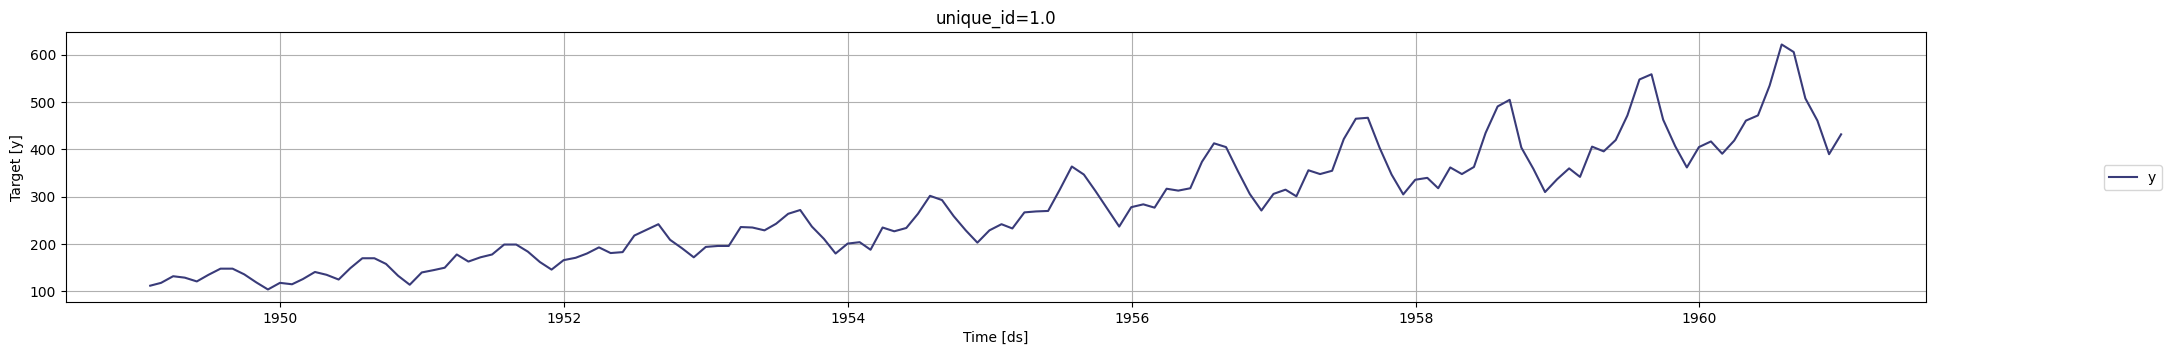

In [4]:
StatsForecast.plot(Y_df)

In [5]:
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length = 12),
    AutoETS(season_length = 12),
    SeasonalNaive(season_length=12)
]


In [6]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='M', 
    fallback_model = SeasonalNaive(season_length=12),
    n_jobs=-1,
)


In [7]:
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])
forecasts_df.head()


,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
0,1.0,1961-01-31,444.300049,424.971436,463.628693,442.357178,406.054108,478.660248,417.0,297.53183,536.46814
1,1.0,1961-02-28,418.210022,394.616974,441.803070,428.267365,389.757538,466.777191,391.0,271.53183,510.46817
2,1.0,1961-03-31,446.237030,418.134003,474.340057,492.974792,451.721527,534.228027,419.0,299.53183,538.46814
3,1.0,1961-04-30,488.228943,456.491608,519.966248,477.369995,433.699768,521.040222,461.0,341.53183,580.46814
4,1.0,1961-05-31,499.231354,464.168854,534.293884,477.602814,431.639618,523.566040,472.0,352.53183,591.46814


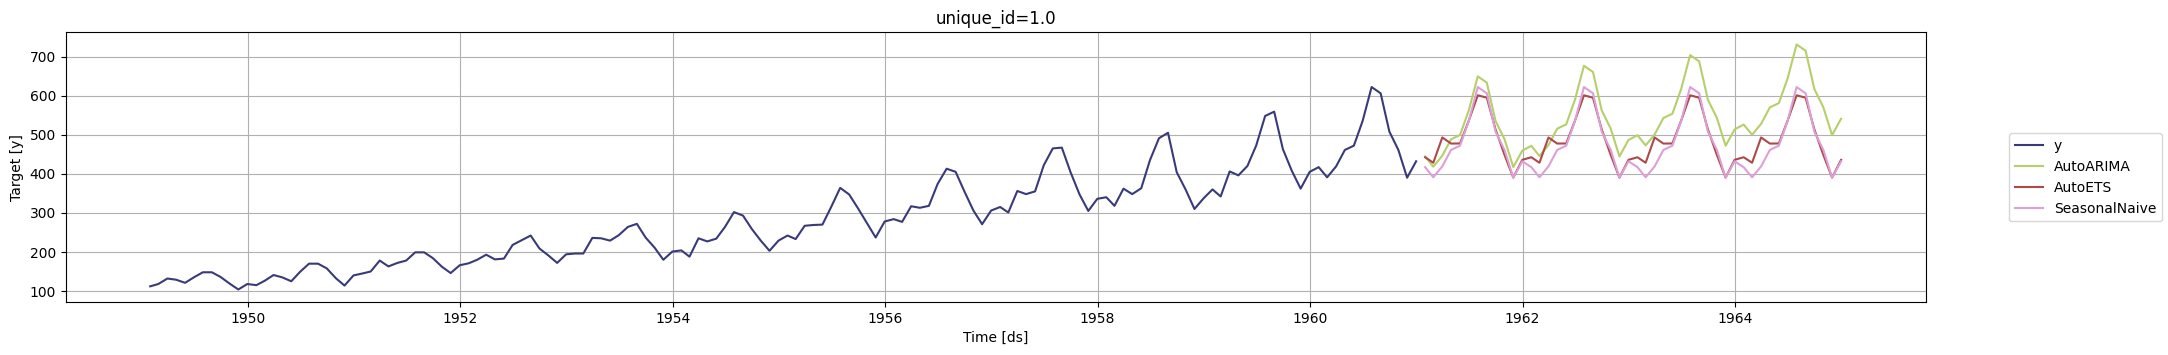

In [8]:
sf.plot(Y_df,forecasts_df)

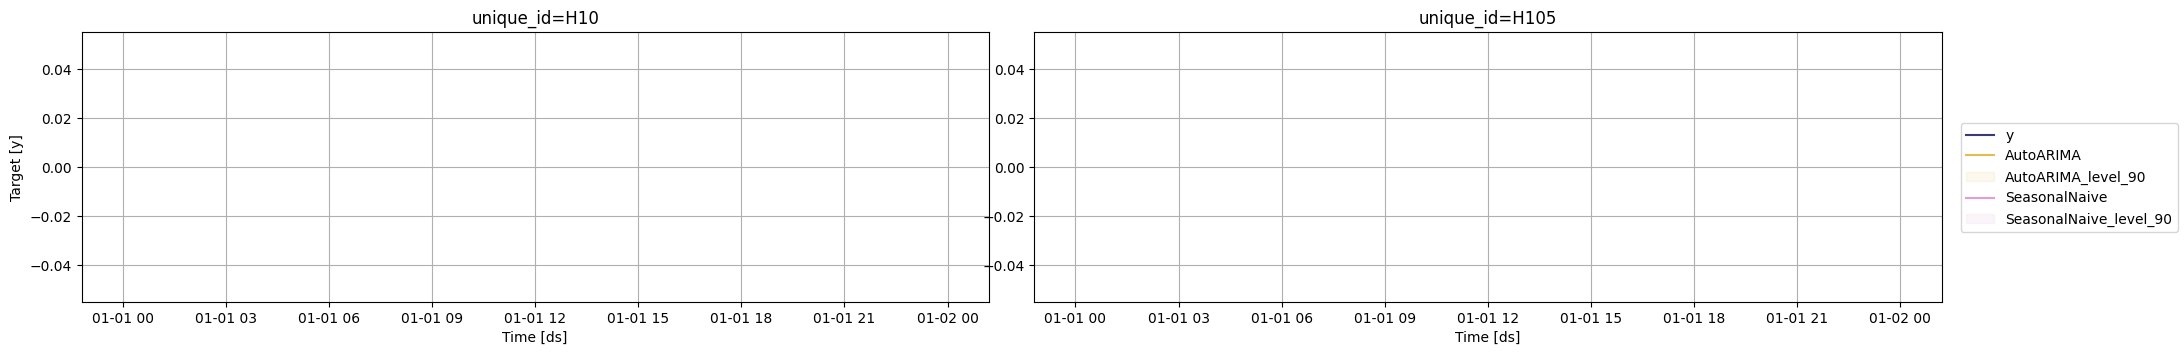

In [9]:
# Plot to unique_ids and some selected models
sf.plot(Y_df, forecasts_df, models=["AutoARIMA","SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])


In [10]:
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2
)


In [11]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate


In [12]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [13]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()


,AutoARIMA,AutoETS,SeasonalNaive,best_model
unique_id,,,,
1.0,2942.248535,4142.321289,4177.229004,AutoARIMA
